In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os, time 
import sys
from memory_profiler import memory_usage
from scipy import sparse

import torch
import STAGATE_pyG
#import STAGATE


from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
start_time = time.time()  # Start time
memory_before = memory_usage()[0]  # Memory before execution

In [3]:
section_id = '151676'

#input_dir = os.path.join('Data', section_id)
#adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
#adata.var_names_make_unique()
adata=sc.read_h5ad('inputQuery/spatial_aba.h5ad')

print(adata.X)

print('1',adata)
index=[]
for i in range(len(adata.obs_names)):
    flag=1
    if adata.obs['nico_ct'][i]=='NM':
        flag=0
    if adata.obs['nico_ct'][i]=='Cycling/GC B cell':
        flag=1
    if adata.obs['nico_ct'][i]=='pDC':
        flag=1
    if flag==1:
        index.append(i)

adata=adata[index]
print('2',adata)

#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# read the annotation
#Ann_df = pd.read_csv(os.path.join('Data', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
#Ann_df.columns = ['Ground Truth']

#adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata.obs['Ground Truth'] = adata.obs['nico_ct']

#adata.X = sparse.csr_matrix(adata.X)

  (0, 1)	10.0
  (0, 2)	1.0
  (0, 3)	2.0
  (0, 5)	4.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 10)	2.0
  (0, 23)	5.0
  (0, 24)	8.0
  (0, 30)	14.0
  (0, 31)	5.0
  (0, 32)	7.0
  (0, 34)	1.0
  (0, 38)	3.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 44)	8.0
  (0, 46)	2.0
  (0, 47)	2.0
  (0, 48)	8.0
  (0, 50)	1.0
  (0, 51)	1.0
  (0, 53)	9.0
  (0, 58)	1.0
  (0, 63)	5.0
  :	:
  (44698, 363)	10.0
  (44698, 365)	1.0
  (44698, 366)	1.0
  (44698, 368)	1.0
  (44698, 374)	1.0
  (44698, 378)	2.0
  (44698, 382)	1.0
  (44698, 394)	1.0
  (44698, 405)	1.0
  (44698, 409)	1.0
  (44698, 416)	7.0
  (44698, 421)	1.0
  (44698, 425)	1.0
  (44698, 426)	2.0
  (44698, 431)	1.0
  (44698, 434)	2.0
  (44698, 435)	2.0
  (44698, 441)	2.0
  (44698, 450)	2.0
  (44698, 451)	1.0
  (44698, 457)	3.0
  (44698, 481)	1.0
  (44698, 487)	1.0
  (44698, 495)	10.0
  (44698, 541)	1.0
1 AnnData object with n_obs × n_vars = 44699 × 550
    obs: 'brain_section_label', 'cluster', 'domain', 'nico_ct', 'x', 'y'
    var: 'gene_symbol', 'transcript_identifier'

------Calculating spatial graph...
The graph contains 234706 edges, 44699 cells.
5.2508 neighbors per cell on average.


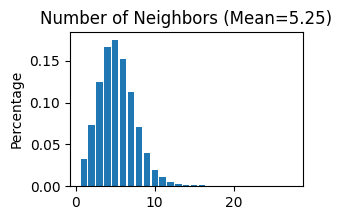

In [4]:
#Constructing the spatial network

STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=0.03)
STAGATE_pyG.Stats_Spatial_Net(adata)

In [5]:
#Running STAGATE with cell type-aware module
#Parameter alpha is the weight of the cell type-aware spatial network, 
# and pre_resolution is the resolution parameter of pre-clustering.
#adata = STAGATE.train_STAGATE(adata2, alpha=0,save_attention=True)
#adata = STAGATE.train_STAGATE(adata, alpha=0.5, pre_resolution=0.2,        n_epochs=1000, save_attention=True)
adata = STAGATE_pyG.train_STAGATE(adata, device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))


print(adata)

Size of Input:  (44699, 550)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [30:52<00:00,  1.85s/it]


AnnData object with n_obs × n_vars = 44699 × 550
    obs: 'brain_section_label', 'cluster', 'domain', 'nico_ct', 'x', 'y', 'Ground Truth'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'STAGATE'


In [6]:
adata.write_h5ad('stagate_intestine.h5ad')

In [10]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
# pre-clustering result
#plt.rcParams["figure.figsize"] = (3, 3)
#sc.pl.spatial(adata,  color="nico_ct", size=1.5, title='pre-clustering result')


In [9]:
sc.tl.louvain(adata,resolution=0.5,key_added="louvain0.5")
sc.tl.louvain(adata,resolution=0.8,key_added="louvain0.8")
sc.tl.louvain(adata,resolution=1,key_added="louvain1")
sc.tl.louvain(adata,resolution=0.2,key_added="louvain0.2")

KeyError: 'No "neighbors" in .uns'

In [ ]:
adata

In [ ]:
adata.write_h5ad('stagate_intestine.h5ad')

In [ ]:

end_time = time.time()  # End time
memory_after = memory_usage()[0]  # Memory after execution
execution_time = end_time - start_time  # Execution time
memory_used = memory_after - memory_before  # Memory used
print("execution_time, memory_used")
print(execution_time, memory_used)

In [ ]:
#Visualization of the attention layer
import matplotlib as mpl
import networkx as nx

In [ ]:
att_df = pd.DataFrame(adata.uns['STAGATE_attention'][0].toarray(), index=adata.obs_names, columns=adata.obs_names)
att_df = att_df.values
for it in range(att_df.shape[0]):
    att_df[it, it] = 0

In [ ]:
G_atten = nx.from_numpy_matrix(att_df)
M = G_atten.number_of_edges()
edge_colors = range(2, M + 2)

In [ ]:
coor_df = pd.DataFrame(adata.obsm['spatial'].copy(), index=adata.obs_names)
coor_df[1] = -1 * coor_df[1]
image_pos = dict(zip(range(coor_df.shape[0]), [np.array(coor_df.iloc[it,]) for it in range(coor_df.shape[0])]))


In [ ]:
labels = nx.get_edge_attributes(G_atten,'weight')

fig, ax = plt.subplots(figsize=[9,10])
nx.draw_networkx_nodes(G_atten, image_pos, node_size=5, ax=ax)
cmap = plt.cm.plasma
edges = nx.draw_networkx_edges(G_atten, image_pos, edge_color=labels.values(),width=4, ax=ax,
                               edge_cmap=cmap,edge_vmax=0.25,edge_vmin=0.05)
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0.05, vmax=0.25))
sm._A = []
plt.colorbar(sm)
ax.set_axis_off()